# Log Likelihood Debugging
Getting weird values for log likelihood when we extend p to be 0 and 1 beyond the bins that have persons in them.

In [212]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import logging
import matplotlib.pyplot as plt
import nirt.simulate.simulate_data
import nirt.solver
import numpy as np

%load_ext autoreload
%autoreload 2

for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")
# For deterministic results.
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# Generate synthetic data.
# Number of persons.
P = 10000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 5
# Using 2-PL model with fixed discrimination and no asymptote for all items.
x, theta, b, c = \
    nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym=0, discrimination=1)
print("theta range {} {}".format(min(theta.flatten()), max(theta.flatten())))
for d in range(C):
    print(d, min(theta[:,d]), max(theta[:,d]))
print(np.percentile(theta, [5, 95], axis=0))
print("Dimension of item {}".format(c))

theta range -7.273709788664184 7.288521196125131
0 -5.002544501493815 4.2940338707593115
1 -7.273709788664184 7.288521196125131
2 -5.173123729322939 5.621227593839513
3 -4.907395027940306 5.164623324147937
4 -4.087319286733457 3.8515093869423502
[[-2.18549686 -2.82706208 -2.30827219 -2.09501407 -1.81065374]
 [ 2.10162476  2.80448738  2.25257617  2.10945136  1.77044532]]
Dimension of item [0 2 1 4 4 0 0 0 1 1 1 3 2 2 3 3 4 2 3 4]


In [214]:
def initial_guess(x, c):
    C = max(c) - 1
    I = x.shape[1]
    """Returns the initial guess for theta."""
    # Person means for each subscale (dimension): P x C
    x_of_dim = np.array([np.mean(x[:, np.where(c == d)[0]], axis=1) for d in range(C)]).transpose()
    # Population mean and stddev of each dimension.
    population_mean = x_of_dim.mean(axis=0)
    population_std = x_of_dim.std(axis=0)
    return (x_of_dim - population_mean) / population_std

In [215]:
# Build an IRF from some reasonable theta values.
num_bins = 10
sample_size = 20
theta = initial_guess(x, c)
bins = nirt.irf.sample_bins(theta[:, 0], num_bins, sample_size)
irf = nirt.irf.ItemResponseFunction.merge([nirt.irf.histogram(x[:, i], bins) for i in range(I)])

Dimension 0, items [0 5 6 7]


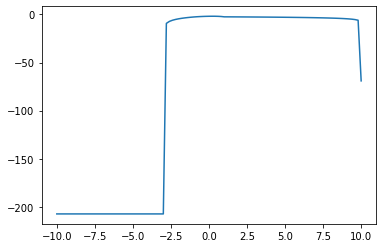

In [216]:
likelihood = nirt.likelihood.Likelihood(x, c, irf)

p = 1
d = 0 # np.random.choice(np.arange(C), 1)[0]
items = np.where(c == d)[0]
print("Dimension {}, items {}".format(d, items))
# See that we can find this minimum with a root finder.
t = likelihood.parameter_mle(p, d)

grid = np.linspace(-nirt.irf.M, nirt.irf.M, 10 * num_bins + 1)
active = np.tile([p, d], (grid.size, 1))
likelihood_values = likelihood.log_likelihood_term(grid, active=(active[:, 0], active[:, 1]))
mle = likelihood.log_likelihood_term(t, (np.array([p]), np.array([d])))[0]
#print(list(grid))
#print(list(likelihood_values))
#print(t, mle)
plt.plot(grid, likelihood_values)

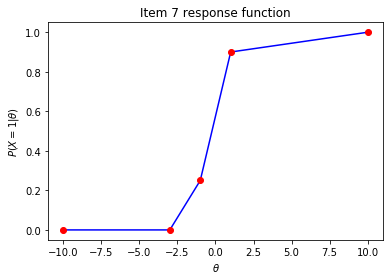

In [217]:
for i in items:
    likelihood.plot_irf(i)

In [218]:
for i in items:
    print(irf.count[i], irf.probability[i])

[ 0  0  0 20 20 20  0  0  0  0] [0.   0.   0.   0.   0.65 1.   0.   0.   0.   0.  ]
[ 0  0  0 20 20 20  0  0  0  0] [0.   0.   0.   0.   0.45 0.9  0.   0.   0.   0.  ]
[ 0  0  0 20 20 20  0  0  0  0] [0.   0.   0.   0.   0.3  0.85 0.   0.   0.   0.  ]
[ 0  0  0 20 20 20  0  0  0  0] [0.   0.   0.   0.   0.25 0.9  0.   0.   0.   0.  ]


In [219]:
x[:,12]

array([1, 0, 0, ..., 1, 1, 0])

In [220]:
theta[:,1]

array([-1.09850683,  0.45086811, -1.09850683, ..., -0.32381936,
        0.45086811,  1.22555557])

In [221]:
nirt.irf.bin_centers(num_bins)

array([-9., -7., -5., -3., -1.,  1.,  3.,  5.,  7.,  9.])

In [222]:
nirt.irf.sample_bins(theta[:,1], num_bins, sample_size)

array([array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64),
       array([8113, 2476, 2949, 2861, 9438,  547, 8851, 2349, 4000, 8820, 6086,
       8264, 1662, 1412, 7517, 2819, 9986, 5506,  144, 4314]),
       array([3889, 6260, 4334, 1607, 5947, 4442,  309, 3887, 4099,  324,  290,
       8249,  631, 7782, 4339, 8506, 7911, 2488,  137, 2883]),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64), array([], dtype=int64)], dtype=object)

In [223]:
theta.shape

(10000, 3)

In [224]:
min(theta.flatten())

-2.812655612056258

In [225]:
theta

array([[ 0.01299801, -1.09850683,  1.29461101],
       [ 0.01299801,  0.45086811, -0.66766411],
       [ 0.01299801, -1.09850683, -0.66766411],
       ...,
       [ 0.95488255, -0.32381936,  1.29461101],
       [ 0.01299801,  0.45086811,  0.31347345],
       [-0.92888653,  1.22555557, -0.66766411]])

In [226]:
for d in range(C):
    print(d, min(theta[:,d]), max(theta[:,d]))

0 -2.812655612056258 0.9548825462134598
1 -1.873194297464026 1.2255555742713353
2 -1.6488016671274097 2.2757485670348268


IndexError: index 3 is out of bounds for axis 1 with size 3